[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana6/2_Hierarchical_Risk_Parity.ipynb) 

# Introducción

Critical Line Algorithm (CLA) es un algoritmo para obtener portafolios con mínima varianza sin la necesidad de utilizar programación cuadrática.

Obtenido de 

> David H. Bailey and Marcos Lopez de Prado, "An open-source implementation of the critical line algorithm for portfolio optimization," Algorithms, vol. 6 (2013), pg. 169-196, DOI: 10.3390/a6010169

Se puede encontrar la [publicación](https://ssrn.com/abstract=2197616) y el [código](https://www.davidhbailey.com/dhbpapers/CLA-files.zip) en https://www.davidhbailey.com/dhbpapers/.

In [ ]:
%%writefile CLA.py
#!/usr/bin/env python
# On 20121129
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>

import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l_in is None or l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and (l_out is None or l>l_out):
                        l_out,i_out=l,i                
            #3) decide lambda
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):break
            if l_in is not None and (l_out is None or l_in > l_out):
                self.l.append(l_in)
                f.remove(i_in)
                w[i_in]=bi_in # set value at the correct boundary
            else:
                self.l.append(l_out)
                f.append(i_out)
            #4) compute solution vector
            covarF,covarFB,meanF,wB=self.getMatrices(f)
            covarF_inv=np.linalg.inv(covarF)
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if len(f)==self.mean.shape[0]:
                #5) minimum variance solution
                wF,g=self.computeW(covarF_inv,covarFB,np.zeros(meanF.shape),wB)
                for i in range(len(f)):w[f[i]]=wF[i]
                self.w.append(np.copy(w)) # store solution
                self.g.append(g)
                self.f.append(f[:])
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1]
        if c<0:
            bi=bi[0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if np.all(wB)==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if np.all(wB==None):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        matrix = np.array(matrix)
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

Writing CLA.py


# Dependencia

In [ ]:
!pip install -U scipy yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import random
import numpy as np
import pandas as pd

import yfinance as yf

from scipy.spatial.distance import squareform

from CLA import CLA

# Bases de HRP

El algoritmo consta de 3 grandes pasos:

- Hierarchical Tree Clustering

- Matrix Seriation

- Recursive Bisection

# Funciones

La siguiente función nos crea un portafolio en que los pesos asignados a cada activo se toman como valores inversos a sus varianzas (inversiones mas seguras)

In [ ]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [ ]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

La siguiente función sirve para reorganizar las filas y las columnas de la matriz de covarianzas para que los valores más grandes se queden alrededos de la diagonal. Esta tiene un propiedad útil: Inversiones similares son posicionadas juntas y distintos son puestos lejos unos de otros.

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0,sortIx.shape[0]*2,2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;j = df0.values-numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1],index = i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

La siguiente función regresa los pesos del portafolio de acuerdo al agoritmo de HRP:

Para crear los pesos, se usa la "inverse-variance allocation", el algoritmo es el siguiente:

1. El algoritmo se inicializa:
  
  a. Creando una lista de objetos: $L = \left\{ L_0 \right\}$ con $L_0 = \left\{ n\right\}_{n=1, \dots, N}$

  b. Asignando un peso unitario a todos los objetos: $w_n = 1$, $\forall n = 1, \dots, N$

2. Si $\|L_i\| = 1$, $\forall L_i \in L$ detenerse.
3. Para cada $L_i \in L$ tal que $\|L_i\| > 1$:

  a. bisectar $L_i$ en dos subconjuntos, $L_i^{(1)} \cup L_i^{(2)} = L_i$, donde $\|L_i^{(1)}\| = int\left[ \frac{1}{2}\|L_i\| \right]$, y el orden es preservado

  b. define la varianza de $L_i^{(j)}$, $j = 1, 2$ como la forma cuadrática $\tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^{T}} V_i^{(j)} \tilde{w}_i^{(j)}$, donde $V_i^{(j)}$ es la matriz de covarianza entre los que conforman la bisección $L_i^{(j)}$, y $\tilde{w}_i^{(j)} = diag\left[ V_i^{(j)}\right] ^ {-1} \frac{1}{tr\left[ diag\left[ V_i^{(j)}\right] \right]}$, donde $diag\left[ . \right]$ y $tr \left[ . \right]$ son los operadores diagonal y traza.
  
  c. Calcula el factor de división: $\alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)}+\tilde{V}_i^{(2)}}$, tal que $0 \leq \alpha_i \leq 1$

  d. re-escala los pesos por un factor de $\alpha_i$, $\forall n \in L_i^{(1)}$

  re-escala los pesos por un factor de $\left(1 - \alpha_i \right)$, $\forall n \in L_i^{(1)}$

4. Repite desde el paso 2.

In [ ]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1,index = sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
                  i[j:k] 
                  for i in cItems 
                  for j, k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) 
                  if len(i) > 1
        ] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = getClusterVar(cov,cItems0)
            cVar1 = getClusterVar(cov,cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [ ]:
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

In [ ]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0< = d[i,j]< = 1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5 # distance matrix
    return squareform(dist)

In [ ]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.savefig(path)
    plt.clf();plt.close() # reset pylab
    return

In [ ]:
#NO CORRER (datos de prueba solamente)


# def generateData(nObs,size0,size1,sigma1):
#    # Time series of correlated variables
#    #1) generating some uncorrelated data
#    np.random.seed(seed = 12345); random.seed(12345)
#    x = np.random.normal(0, 1, size = (nObs,size0)) # each row is a variable
#    #2) creating correlation between the variables
#    cols = [random.randint(0, size0 - 1) for i in range(size1)]
#    y = x[:,cols]+np.random.normal(0, sigma1, size = (nObs, len(cols)))
#    x = np.append(x, y, axis = 1)
#    x = pd.DataFrame(x, columns = range(1, x.shape[1] + 1))
#    return x, cols

In [ ]:
def get_allocations(x, return_linkage = False):
    #1) Load the data
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
    #3) cluster
    dist = correlDist(corr)
    link = sch.linkage(dist,'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels
    df0 = corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
    #4) Capital allocation
    hrp = getRecBipart(cov,sortIx)
    allocation = hrp.to_frame(name = 'HRP').sort_index()
    allocation['CLA'] = np.round(getCLA(cov), 6)
    if return_linkage:
        return allocation, link
    return allocation

# Datos

Utilizaremos las acciones de diversas compañias especializadas en tecologías relacionada a informática: Apple, IBM, Microsoft, Palantir Tech, Fastly, CloudFlare, Datadog, Zscaler, Snowflake.

In [ ]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        # tickers = "GOOG AAPL IBM MSFT FB NFLX AMZN PLTR FSLY NET DDOG ZS SNOW",
        tickers = "AAPL IBM MSFT PLTR FSLY NET DDOG ZS SNOW",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close'].dropna()
data

[*********************100%***********************]  9 of 9 completed


,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-08-05,146.224594,132.470001,39.930000,129.999084,287.175049,121.459999,22.52,276.989990,247.669998
2021-08-06,145.527527,131.919998,41.240002,131.201019,287.115540,118.820000,21.82,277.480011,242.050003
2021-08-09,145.477722,130.000000,44.040001,130.095764,285.994690,123.430000,22.93,280.000000,245.039993
2021-08-10,144.989792,125.300003,42.299999,130.215515,284.119995,125.470001,22.92,274.489990,240.500000
2021-08-11,145.248703,128.210007,42.080002,130.906296,284.625885,119.010002,22.35,275.869995,237.669998
...,...,...,...,...,...,...,...,...,...
2022-07-29,162.509995,102.010002,11.370000,130.789993,280.739990,50.320000,10.35,149.910004,155.059998
2022-08-01,161.509995,103.449997,11.500000,132.039993,278.010010,51.160000,10.47,150.979996,153.500000
2022-08-02,160.009995,106.370003,12.310000,131.809998,274.820007,53.080002,10.92,153.369995,157.779999


# Rendimientos

In [ ]:
x = np.log(data / data.shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-08-06,-1.204182,-1.048458,8.134754,2.319216,-0.052226,-5.537761,-7.957368,0.445417,-5.784125
2021-08-09,-0.086258,-3.694626,16.553787,-2.131874,-0.985690,9.592243,12.504024,2.278258,3.093831
2021-08-10,-0.846625,-9.279538,-10.158439,0.231855,-1.657297,4.130910,-0.109926,-5.008452,-4.712739
2021-08-11,0.449600,5.785595,-1.314043,1.333302,0.448300,-13.320507,-6.346256,1.263762,-2.982909
2021-08-12,5.181255,4.036126,5.274263,1.661124,2.499211,6.727645,27.125218,9.334238,5.526703
...,...,...,...,...,...,...,...,...,...
2022-07-29,8.131244,16.038185,-0.884987,3.043289,3.917001,8.505193,5.414277,11.399066,3.271499
2022-08-01,-1.555465,3.532412,2.864922,2.397005,-2.462499,4.171953,2.904928,1.792277,-2.548112
2022-08-02,-2.351348,7.014479,17.152365,-0.439332,-2.908270,9.284252,10.604646,3.957892,6.930273


# Portafolios

{'color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C0'],
 'dcoord': [[0.0, 0.3341103370418185, 0.3341103370418185, 0.0],
  [0.0, 0.3060093139086212, 0.3060093139086212, 0.0],
  [0.0, 0.3080507565225508, 0.3080507565225508, 0.0],
  [0.3060093139086212, 0.3242474904058, 0.3242474904058, 0.3080507565225508],
  [0.0, 0.35370808960955386, 0.35370808960955386, 0.0],
  [0.3242474904058,
   0.35878411391603177,
   0.35878411391603177,
   0.35370808960955386],
  [0.3341103370418185,
   0.41131361535093264,
   0.41131361535093264,
   0.35878411391603177],
  [0.0, 0.5985212069991954, 0.5985212069991954, 0.41131361535093264]],
 'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [40.0, 40.0, 60.0, 60.0],
  [75.0, 75.0, 85.0, 85.0],
  [50.0, 50.0, 80.0, 80.0],
  [20.0, 20.0, 65.0, 65.0],
  [5.0, 5.0, 42.5, 42.5]],
 'ivl': ['3', '0', '4', '1', '7', '5', '8', '2', '6'],
 'leaves': [3, 0, 4, 1, 7, 5, 8, 2, 6],
 'leaves_color_list': ['C0', 'C1', 'C1', 

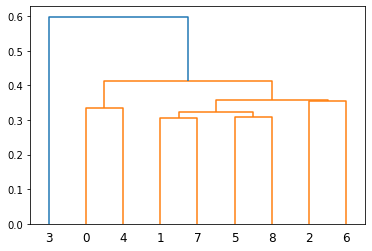

In [ ]:
allocation, linkage = get_allocations(x, True)
sch.dendrogram(linkage)

In [ ]:
allocation

,HRP,CLA
AAPL,0.240376,0.000000
DDOG,0.039035,0.000000
FSLY,0.009748,0.000000
IBM,0.411158,0.650877
MSFT,0.212625,0.349123
NET,0.016825,0.000000
PLTR,0.015663,0.000000
SNOW,0.025954,0.000000
ZS,0.028617,0.000000


Inversion en las primeras 24 semanas

In [ ]:
start = 0
end = 24

data_weekly = [g[1] for g in list(data.groupby(pd.Grouper(freq = 'W')))]
print(len(data_weekly))
data_weekly[0]

53


,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-08-05,146.224594,132.470001,39.930000,129.999084,287.175049,121.459999,22.52,276.989990,247.669998
2021-08-06,145.527527,131.919998,41.240002,131.201019,287.115540,118.820000,21.82,277.480011,242.050003


In [ ]:
portfolio_data = pd.concat(data_weekly[start:end])
portfolio_data

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-08-05,146.224594,132.470001,39.930000,129.999084,287.175049,121.459999,22.520000,276.989990,247.669998
2021-08-06,145.527527,131.919998,41.240002,131.201019,287.115540,118.820000,21.820000,277.480011,242.050003
2021-08-09,145.477722,130.000000,44.040001,130.095764,285.994690,123.430000,22.930000,280.000000,245.039993
2021-08-10,144.989792,125.300003,42.299999,130.215515,284.119995,125.470001,22.920000,274.489990,240.500000
2021-08-11,145.248703,128.210007,42.080002,130.906296,284.625885,119.010002,22.350000,275.869995,237.669998
...,...,...,...,...,...,...,...,...,...
2022-01-10,171.718597,146.330002,33.349998,131.823746,312.892761,110.750000,16.500000,302.730011,275.649994
2022-01-11,174.600693,148.600006,34.250000,129.715042,313.599670,114.139999,16.889999,301.269989,277.529999
2022-01-12,175.049454,146.330002,33.209999,130.417938,316.875214,113.970001,16.719999,307.140015,273.980011


In [ ]:
x = np.log(portfolio_data / portfolio_data.shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-08-06,-1.204182,-1.048458,8.134754,2.319216,-0.052226,-5.537761,-7.957368,0.445417,-5.784125
2021-08-09,-0.086258,-3.694626,16.553787,-2.131874,-0.985690,9.592243,12.504024,2.278258,3.093831
2021-08-10,-0.846625,-9.279538,-10.158439,0.231855,-1.657297,4.130910,-0.109926,-5.008452,-4.712739
2021-08-11,0.449600,5.785595,-1.314043,1.333302,0.448300,-13.320507,-6.346256,1.263762,-2.982909
2021-08-12,5.181255,4.036126,5.274263,1.661124,2.499211,6.727645,27.125218,9.334238,5.526703
...,...,...,...,...,...,...,...,...,...
2022-01-10,0.029269,4.412647,2.582302,0.373528,0.184480,8.680537,-0.914693,2.551788,13.250898
2022-01-11,4.194423,3.879242,6.710467,-4.063679,0.568694,7.597888,5.887051,-1.218299,1.712871
2022-01-12,0.646863,-3.879242,-7.770560,1.361844,2.618484,-0.375604,-2.549264,4.862814,-3.244218


In [ ]:
allocations = get_allocations(x)
allocations

,HRP,CLA
AAPL,0.155077,0.135432
DDOG,0.040629,0.000000
FSLY,0.051891,0.000000
IBM,0.416525,0.486318
MSFT,0.163586,0.356120
NET,0.021916,0.000868
PLTR,0.052735,0.000000
SNOW,0.048255,0.021262
ZS,0.049385,0.000000


In [ ]:
start_price = data_weekly[end-1].iloc[-1, :]
end_price = data_weekly[end].iloc[-1, :]
change = end_price - start_price
change

AAPL   -10.630829
DDOG   -12.729996
FSLY    -3.119999
IBM     -4.744598
MSFT   -14.107910
NET    -11.739998
PLTR    -2.480000
SNOW   -22.029999
ZS     -12.800003
dtype: float64

In [ ]:
allocations.mul(change, 0)

,HRP,CLA
AAPL,-1.648594,-1.439754
DDOG,-0.517213,-0.000000
FSLY,-0.161900,-0.000000
IBM,-1.976246,-2.307384
MSFT,-2.307856,-5.024109
NET,-0.257299,-0.010190
PLTR,-0.130783,-0.000000
SNOW,-1.063058,-0.468402
ZS,-0.632128,-0.000000


In [ ]:
allocations.mul(change, 0).sum()

HRP   -8.695076
CLA   -9.249839
dtype: float64

# Comparación

In [ ]:
start = 0
end = 24

periods_ = range(len(data_weekly) - end)
earnings = np.zeros((len(periods_), 2))
alloc_list = []

for i in periods_:
    portfolio_data = pd.concat(data_weekly[start:end])

    x = np.log(portfolio_data / portfolio_data.shift(periods=5)) # / (1 / 252) # Para anualizar los retornos
    x.dropna(inplace = True)

    allocations = get_allocations(x)
    alloc_list.append(allocations)

    start_price = data_weekly[end-1].iloc[-1, :]
    end_price = data_weekly[end].iloc[-1, :]
    change = end_price - start_price

    earnings[i, :] = allocations.mul(change, 0).sum()

    start += 1
    end += 1

In [ ]:
alloc_list[20]

,HRP,CLA
AAPL,0.224046,0.000000
DDOG,0.027881,0.000000
FSLY,0.024651,0.000000
IBM,0.361426,0.609927
MSFT,0.287927,0.390073
NET,0.007070,0.000000
PLTR,0.024181,0.000000
SNOW,0.029959,0.000000
ZS,0.012859,0.000000


In [ ]:
earnings = pd.DataFrame(earnings, columns = ['HRP', 'CLA'])

In [ ]:
import plotly.express as px
fig = px.line(earnings.cumsum(), markers = True)
fig.update_layout(hovermode = 'x')
fig.show()

In [ ]:
data_weekly[1]

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-08-09,145.477722,130.000000,44.040001,130.095764,285.994690,123.430000,22.930000,280.000000,245.039993
2021-08-10,144.989792,125.300003,42.299999,130.215515,284.119995,125.470001,22.920000,274.489990,240.500000
2021-08-11,145.248703,128.210007,42.080002,130.906296,284.625885,119.010002,22.350000,275.869995,237.669998
2021-08-12,148.266006,130.279999,42.970001,131.772049,287.462708,122.230003,24.889999,286.279999,242.940002
2021-08-13,148.475128,135.490005,42.110001,131.873367,290.478088,121.750000,24.900000,291.519989,245.149994


In [ ]:
alloc_list[1]

,HRP,CLA
AAPL,0.353800,0.064320
DDOG,0.025552,0.000000
FSLY,0.038594,0.000000
IBM,0.314244,0.459429
MSFT,0.144968,0.441341
NET,0.006397,0.000000
PLTR,0.060187,0.034910
SNOW,0.041500,0.000000
ZS,0.014758,0.000000


In [ ]:
px.line(data)